# 1. Install and Import Dependencies

In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image
from copy import deepcopy

/home/cc/miniconda3/envs/central/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Load Model

In [2]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5n')

Using cache found in /home/cc/.cache/torch/hub/ultralytics_yolov5_master
requirements: matplotlib>=3.2.2 not found and is required by YOLOv5, attempting auto-update...
requirements: 'pip install matplotlib>=3.2.2' skipped (offline)
requirements: psutil not found and is required by YOLOv5, attempting auto-update...
requirements: 'pip install psutil' skipped (offline)
YOLOv5 🚀 2022-7-31 Python-3.8.13 torch-1.11.0+cu102 CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


In [3]:
model

AutoShape(
  (model): DetectMultiBackend(
    (model): Model(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
           

# 3. Make Detections with Images

In [4]:
img = 'https://ultralytics.com/images/zidane.jpg'

In [5]:
results = model(img)
results.print()

image 1/1: 720x1280 2 persons, 1 tie
Speed: 209.3ms pre-process, 53.4ms inference, 2.0ms NMS per image at shape (1, 3, 384, 640)


In [6]:
results.display()

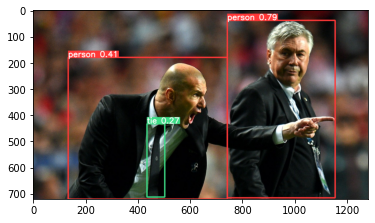

In [7]:
%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()

In [48]:
cropped_results = results.crop()

Saved 1 image to runs/detect/exp44
Saved results to runs/detect/exp44



In [50]:
type(cropped_results)

list

In [ ]:
selected_keys = ['label', 'im']
lst = [
    {key:value for key,value in result.items() if key in selected_keys}
    for result in cropped_results]
lst

In [ ]:
for item in lst:
    item['im'] = item['im'].tolist()

lst

In [8]:
data_folder_path = '/home/cc/my_mounting_point/datasets'
dataset_folder_path = os.path.join(
    data_folder_path, 'ILSVRC/Data/DET/test'
)
classes_file_path = os.path.join(
    data_folder_path, 'imagenet_classes.txt'
)

image_names = os.listdir(dataset_folder_path)
image_names.sort()
with open(classes_file_path) as f:
    classes = [line.strip() for line in f.readlines()]

def image_loader(folder_path, image_name):
    image = Image.open(
        os.path.join(folder_path, image_name))
    # if there was a need to filter out only color images
    # if image.mode == 'RGB':
    #     pass
    return image
num_loaded_images = 17
images = {
    image_name: image_loader(
        dataset_folder_path, image_name) for image_name in image_names[
            :num_loaded_images]}

ConnectionAbortedError: [Errno 103] Software caused connection abort: '/home/cc/my_mounting_point/datasets/ILSVRC/Data/DET/test'

In [ ]:
images

In [15]:
model_results = {}
for image_name, image in images.items():
    model_results[image_name] = model(np.array(image))

In [ ]:
for image_name, image in images.items():
    print(image_name)
    print(np.array(image).shape)
    print(np.array(image).dtype)

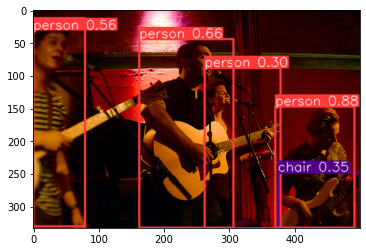

In [17]:
%matplotlib inline
image_num = 1
plt.imshow(np.squeeze(list(model_results.items())[8][image_num].render()))
plt.show()


In [18]:
def get_cropped(result):
    """
    crops selected objects for
    the subsequent nodes
    """
    result = result.crop()
    liscense_labels = ['car', 'truck']
    car_labels = ['car']
    person_labels = ['person']
    output_list = {'person': [], 'car': [], 'liscense': []}
    for obj in result:
        for label in liscense_labels:
            if label in obj['label']:
                output_list['liscense'].append(deepcopy(obj['im']))
                break
        for label in car_labels:
            if label in obj['label']:
                output_list['car'].append(deepcopy(obj['im']))
                break
        for label in person_labels:
            if label in obj['label']:
                output_list['person'].append(deepcopy(obj['im']))
                break
    return output_list

In [ ]:
crop_results = {}
for image_name, result in model_results.items():
    crop_results[image_name] = get_cropped(result)

In [ ]:
crop_results

In [22]:
len(list(crop_results.items())[8][1]['person'])

4

In [ ]:
%matplotlib inline
image_num = 1
plt.imshow(list(crop_results.items())[2][image_num]['person'][0])
plt.show()

In [ ]:
list(crop_results.items())[2][image_num]['person'][0].shape

In [25]:
import os
import numpy as np
import torch
from torchvision import models
from torchvision import transforms

def predict(X, features_names=None):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])
    X_trans = Image.fromarray(X.astype(np.uint8))
    X_trans = transform(X_trans)
    batch = torch.unsqueeze(X_trans, 0)
    resnet = models.resnet101(pretrained=True)
    resnet.eval()
    out = resnet(batch)
    percentages = torch.nn.functional.softmax(out, dim=1)[0] * 100
    percentages = percentages.detach().numpy()
    image_net_class = np.argmax(percentages)
    return image_net_class


In [ ]:
import os
import numpy as np
import torch
from torchvision import models
from torchvision import transforms

def predict(X, features_names=None):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])
    if X['person'] == []:
        return []
    X = X['person']
    X_trans = [transform(Image.fromarray(image)) for image in X]
    batch = torch.stack(X_trans, axis=0)
    # batch = torch.unsqueeze(X_trans, 0)
    resnet = models.resnet101(pretrained=True)
    resnet.eval()
    out = resnet(batch)
    percentages = torch.nn.functional.softmax(out, dim=1) * 100
    percentages = percentages.detach().numpy()
    image_net_class = np.argmax(percentages, axis=1)
    return image_net_class.tolist()

image_num = 8

predict(list(crop_results.items())[image_num][1]['person'])

In [22]:
a = model(np.array(images['ILSVRC2017_test_00000001.JPEG'], dtype=float))

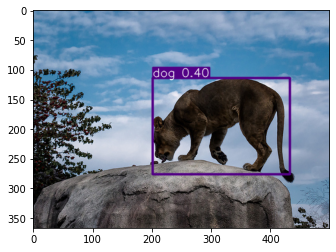

In [29]:
%matplotlib inline
plt.imshow(np.squeeze(a.render()))
plt.show()

In [ ]:
np.array(np.array(images['ILSVRC2017_test_00000001.JPEG'], dtype=float), dtype=np.uint8).dtype

In [ ]:
np.array(images['ILSVRC2017_test_00000001.JPEG']).dtype

In [ ]:
image_num = 1
list(crop_results.items())[2][image_num]['person'][0]

In [ ]:
list(crop_results.items())[image_num][1]

In [81]:
len(list(crop_results.items())[8][1]['person'])

4

In [ ]:
list(crop_results.items())[image_num][1]['person']